In [2]:
# declare a list tasks whose products you want to use as inputs
upstream = None


In [3]:
# Imports and Setup
import pandas as pd
import numpy as np
from pathlib import Path
import sys
import logging
import json
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Add project root to path
sys.path.append(str(Path.cwd().parent))

# Import modules
from src.models.predictor import TrollPredictor
from src.data_tools.czech_data_tools import load_czech_media_data
from src.data_tools.czech_data_tools import export_comments_by_prediction

# Configure matplotlib and seaborn
plt.style.use('default')
sns.set_theme()

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [4]:
DATA_DIR = Path('data')

# Initialize predictor with model
# model_path = "./checkpoints/best_model.pt"
model_path = "./checkpoints/finetuned_model.pt"

# Initialize predictor with threshold
predictor = TrollPredictor(
    model_path=model_path,
    comments_per_user=10,
    max_length=96,
    threshold=0.5  # Add threshold parameter
)

INFO:src.models.predictor:Loaded model weights from ./checkpoints/finetuned_model.pt


In [6]:
DATA_DIR = Path('data')

# Initialize predictor with model
# model_path = "./checkpoints/best_model.pt"
model_path = "./checkpoints/finetuned_model.pt"

# Initialize predictor with threshold
predictor = TrollPredictor(
    model_path=model_path,
    comments_per_user=10,
    max_length=96,
    threshold=0.5  # Add threshold parameter
)

INFO:src.models.predictor:Loaded model weights from ./checkpoints/finetuned_model.pt


In [19]:
# DATA_DIR = Path('./data')
# czech_comments = load_czech_media_data(str(DATA_DIR / 'MediaSource'))
# print(f"Loaded {len(czech_comments)} comments from {czech_comments['author'].nunique()} unique authors")

# Read the processed Czech media comments from parquet file
czech_comments = pd.read_parquet("data/processed/czech_media_comments.parquet")
print(f"Loaded {len(czech_comments)} comments from {czech_comments['author'].nunique()} unique authors")

Loaded 845764 comments from 66590 unique authors


In [23]:
# Get authors with at least 10 comments and reduce to 50% of those
author_counts = czech_comments['author'].value_counts()
eligible_authors = author_counts[author_counts >= 10].index
sample_size = int(len(eligible_authors) * 0.5)
sampled_authors = np.random.choice(eligible_authors, size=sample_size, replace=False)
czech_comments = czech_comments[czech_comments['author'].isin(sampled_authors)]

print(f"Reduced to {len(czech_comments)} comments from {sample_size} authors (all with 10+ comments)")


Reduced to 86413 comments from 2068 authors (all with 10+ comments)


In [17]:
# Load labeled authors from annotations file
labeled_authors_df = pd.read_csv('annotations/user_labels.csv')
labeled_authors = labeled_authors_df['author'].unique()

# Filter czech_comments to only include labeled authors
czech_comments_annotated = czech_comments[czech_comments['author'].isin(labeled_authors)]

print(f"Filtered to {len(czech_comments)} comments from {len(labeled_authors)} labeled authors")
predictions_df_labeled = predictor.predict(czech_comments_annotated)

Filtered to 46415 comments from 54 labeled authors


100%|█████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  4.84it/s]


In [24]:
PREDICTIONS_DIR = Path('output')

# Make predictions
predictions_df = predictor.predict(czech_comments)



100%|███████████████████████████████████████████████████████████████████████████████| 2068/2068 [02:17<00:00, 14.99it/s]


In [25]:
# Combine labeled and unlabeled predictions, skipping duplicates
predictions_df = pd.concat([predictions_df_labeled, predictions_df], axis=0).drop_duplicates(subset=['author'], keep='first')


In [26]:
# Save predictions with new columns
predictions_df.to_csv(PREDICTIONS_DIR / 'czech_media_predictions.csv', index=False)

# Update the summary statistics to include regression metrics
summary_stats = {
    'total_authors': len(predictions_df),
    'mean_trolliness': predictions_df['trolliness_score'].mean(),
    'median_trolliness': predictions_df['trolliness_score'].median(),
    'std_trolliness': predictions_df['trolliness_score'].std(),
    'troll_percentage': (predictions_df['binary_prediction'] == 'troll').mean() * 100,
    'mean_confidence': predictions_df['binary_confidence'].mean(),
    'threshold_used': predictor.threshold
}

# Save summary
with open(PREDICTIONS_DIR / 'prediction_summary0.1.json', 'w') as f:
    json.dump(summary_stats, f, indent=2)

In [27]:
# Create a mapping of labels to numeric values for correlation analysis
label_map = {'troll': 1, 'not_troll': 0}
labeled_authors_df['label_numeric'] = labeled_authors_df['label'].map(label_map)

# Merge predictions with labeled data
merged_df = predictions_df.merge(
    labeled_authors_df[['author', 'label', 'label_numeric']], 
    on='author',
    how='inner'
)

print("\nComparison of Predictions vs Manual Labels:")
print("=" * 80)
print(f"\nTotal labeled authors: {len(merged_df)}")
print(f"Average trolliness score:")
print(merged_df.groupby('label')['trolliness_score'].agg(['mean', 'count', 'std']))

# Calculate correlation between trolliness score and numeric labels
correlation = merged_df['trolliness_score'].corr(merged_df['label_numeric'])
print(f"\nCorrelation between trolliness score and manual labels: {correlation:.3f}")

# Create confusion matrix using threshold
threshold = predictor.threshold
merged_df['predicted_label'] = (merged_df['trolliness_score'] > threshold).astype(int)
confusion = pd.crosstab(
    merged_df['label_numeric'], 
    merged_df['predicted_label'],
    margins=True
)
print("\nConfusion Matrix (using threshold):")
print(confusion)



Comparison of Predictions vs Manual Labels:

Total labeled authors: 14
Average trolliness score:
           mean  count       std
label                           
-1     0.654866      6  0.241740
 0     0.481517      5  0.203853
 1     0.764801      3  0.075615

Correlation between trolliness score and manual labels: nan

Confusion Matrix (using threshold):
Empty DataFrame
Columns: []
Index: []


In [15]:
# Get comment counts per author
author_comment_counts = czech_comments['author'].value_counts()
authors_with_min_comments = author_comment_counts[author_comment_counts >= 5].index

# Get top 10 authors by trolliness score who have at least 5 comments
top_trolls = predictions_df[predictions_df['author'].isin(authors_with_min_comments)].nlargest(10, 'trolliness_score')

# Save top trolls to CSV with just name, score and label (if available)
top_trolls_save = top_trolls[['author', 'trolliness_score']].copy()
top_trolls_save['label'] = top_trolls_save['author'].map(
    labeled_authors_df.set_index('author')['label']
)
top_trolls_save.to_csv(PREDICTIONS_DIR / 'top_trolls.csv', index=False)

print("\nTop 10 Authors by Trolliness Score (with 5+ comments):")
print("=" * 80)

# Print details for each author
for _, author_row in top_trolls.iterrows():
    author = author_row['author']
    score = author_row['trolliness_score']
    
    # Get label if available
    label = "Unlabeled"
    if author in labeled_authors_df['author'].values:
        label_val = labeled_authors_df[labeled_authors_df['author'] == author]['label'].iloc[0]
        label = label_map.get(label_val, "Unlabeled")
    
    print(f"\nAuthor: {author}")
    print(f"Trolliness Score: {score:.3f}")
    print(f"Manual Label: {label}")
    
    # Get 5 sample comments
    author_comments = czech_comments[czech_comments['author'] == author]['text'].head()
    print("\nSample Comments:")
    for i, comment in enumerate(author_comments, 1):
        print(f"\n{i}. {comment}")
    print("\n" + "-" * 80)


Top 10 Authors by Trolliness Score (with 5+ comments):

Author: Jirka Alex
Trolliness Score: 0.783
Manual Label: Unlabeled

Sample Comments:

1. Prazdna slova

2. Prazdna slova

3. Brno je zlata lod'

4. Pozvou nas?

5. Na samote u lesa

--------------------------------------------------------------------------------

Author: Ivan Penzes
Trolliness Score: 0.758
Manual Label: Unlabeled

Sample Comments:

1. Nejlepší zpráva dne ✌️✌️✌️

2. Jeden může, druhý nemůže.To je ta rovnost a demokracie podle dnešních vládních stran.....

3. Ještě nic neudělal a seznam hrozí katastrofou

4. Seznam zase jede bomby

5. Bratislava není Kiev

--------------------------------------------------------------------------------

Author: Zdislava Liďáková
Trolliness Score: 0.749
Manual Label: Unlabeled

Sample Comments:

1. …jako v pohádce Ference a Lorence, jen tím, že tu chybí “loupežník” Karaba! Nezbývá, než vydržet do švestek a věřit, že se ledacos změní

2. Tak to je celkem jasné. Kdo ještě neviděl film

In [20]:
# Count original number of authors and comments
total_authors = czech_comments['author'].nunique()
total_comments = len(czech_comments)
print(f"Loaded {total_comments} comments from {total_authors} unique authors")

# Filter authors with at least 5 comments
author_counts = czech_comments['author'].value_counts()
authors_with_min_5 = author_counts[author_counts >= 5].index
czech_comments = czech_comments[czech_comments['author'].isin(authors_with_min_5)]

# Count filtered number of authors and comments
filtered_authors = czech_comments['author'].nunique()
filtered_comments = len(czech_comments)
print(f"Filtered to {filtered_comments} comments from {filtered_authors} authors with at least 5 comments")
print(f"Removed {total_authors - filtered_authors} authors with fewer than 5 comments")

Loaded 44139 comments from 3329 unique authors
Filtered to 40679 comments from 1265 authors with at least 5 comments
Removed 2064 authors with fewer than 5 comments


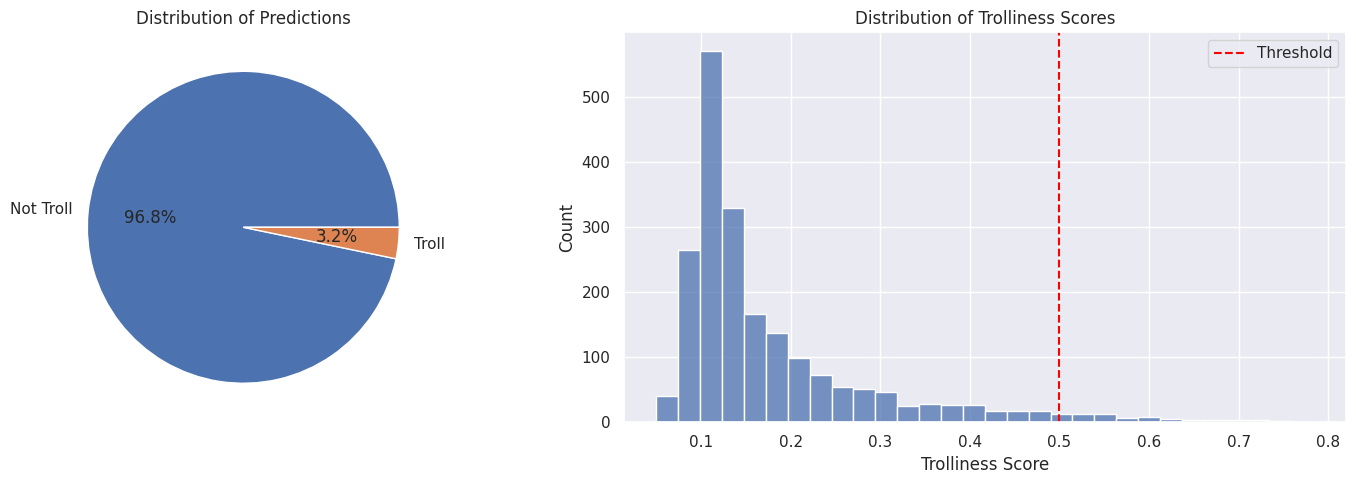


Trolliness Score Statistics:
----------------------------------------
count    2068.000000
mean        0.180452
std         0.117596
min         0.050132
25%         0.107969
50%         0.133828
75%         0.205440
max         0.783330
Name: trolliness_score, dtype: float64


In [16]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Pie chart of troll vs non-troll predictions
predictions = (predictions_df['trolliness_score'] > predictor.threshold).map({True: 'Troll', False: 'Not Troll'})
prediction_counts = predictions.value_counts()

ax1.pie(prediction_counts, labels=prediction_counts.index, autopct='%1.1f%%')
ax1.set_title('Distribution of Predictions')

# Plot 2: Distribution of trolliness scores
sns.histplot(data=predictions_df, x='trolliness_score', bins=30, ax=ax2)
ax2.axvline(x=predictor.threshold, color='red', linestyle='--', label='Threshold')
ax2.set_title('Distribution of Trolliness Scores')
ax2.set_xlabel('Trolliness Score')
ax2.set_ylabel('Count')
ax2.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nTrolliness Score Statistics:")
print("-" * 40)
print(predictions_df['trolliness_score'].describe())


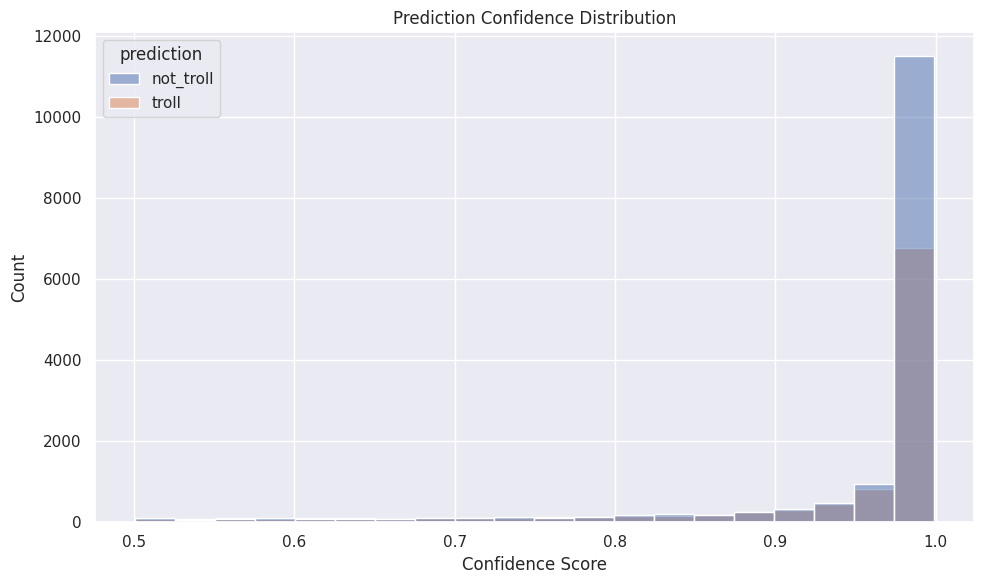

In [15]:
# Cell: Analyze predictions by confidence levels
# Create visualization
plt.figure(figsize=(10, 6))
sns.histplot(
    data=results_df, 
    x='confidence', 
    hue='prediction', 
    bins=20
)
plt.title('Prediction Confidence Distribution')
plt.xlabel('Confidence Score')
plt.ylabel('Count')
plt.tight_layout()
plt.show()




In [17]:
# Save a sample of troll and not_troll classified comments

export_comments_by_prediction(
    predictions_df=results_df,
    comments_df=czech_comments,
    prediction_class='troll',
    min_confidence=0.7,
    max_confidence=1,
    max_authors=50,
    output_file="../output/troll_comments.json"
)

export_comments_by_prediction(
    predictions_df=results_df,
    comments_df=czech_comments,
    prediction_class='not_troll',
    min_confidence=0.8,
    max_authors=50,
    output_file="../output/non_troll_comments.json"
)

Processing troll comments: 100%|██████████| 50/50 [00:03<00:00, 16.57it/s]



Exported 1096 comments from 50 authors
Output saved to: ../output/troll_comments.json


Processing not_troll comments: 100%|██████████| 50/50 [00:02<00:00, 16.81it/s]


Exported 678 comments from 50 authors
Output saved to: ../output/non_troll_comments.json


In [17]:
def explain_author(
    author_name: str, 
    predictor_instance: TrollPredictor, 
    comments_df: pd.DataFrame, 
    display_plots: bool = True,
):
    """Interactive function to explain why an author was classified as a troll using multiple methods"""
    
    # Get author's comments
    author_comments = comments_df[comments_df['author'] == author_name]['text'].tolist()
    
    if not author_comments:
        print(f'No comments found for author: {author_name}')
        return
        
    # Get prediction first
    pred = predictor_instance.predict_batch(author_comments)
    
    if pred['prediction'] != 'troll':
        print(f'Author {author_name} is not classified as a troll (confidence: {pred["confidence"]:.3f})')
        return
    
    print(f"\nAnalyzing author: {author_name}")
    print(f"Prediction confidence: {pred['confidence']:.3f}")
    print(f"Troll probability: {pred['probabilities'][1]:.3f}")
    
    # Generate occlusion sensitivity explanation
    print("\n=== Occlusion Sensitivity Analysis ===")
    explanation = predictor_instance.explain_prediction(author_comments)
    
    # Print occlusion sensitivity results
    for i, exp in enumerate(explanation['explanations'], 1):
        print(f"\nComment {i}:")
        print(f"Text: {exp['tweet_text']}")
        print("\nMost influential tokens (Occlusion Sensitivity):")
        
        # Create a table with token contributions
        contrib_data = []
        for contrib in exp['token_contributions']:
            direction = "Supporting" if contrib['contribution'] == 'positive' else "Opposing"
            contrib_data.append([
                contrib['token'],
                f"{contrib['importance']:.4f}",
                direction
            ])
        
        contrib_df = pd.DataFrame(contrib_data, columns=['Token', 'Importance', 'Effect'])
        print(contrib_df.to_string(index=False))
        
        if display_plots:
            img = plt.imread(exp['plot_filename'])
            plt.figure(figsize=(12, 4))
            plt.imshow(img)
            plt.axis('off')
            plt.title(f'Occlusion Sensitivity Analysis - Comment {i}')
            plt.show()
        
        print("-" * 80)

In [18]:
# Example usage
# authors_to_explain = [
#     "Jitka Bártová",
#     "Roman Myška",   
# ]
authors_to_explain = [
    "Vladimír Furrer",
    "Michal Markó",   
]


for author in authors_to_explain:
    explain_author(
        author_name=author,
        predictor_instance=predictor,
        comments_df=czech_comments,
        display_plots=True,
    )
    print("\n" + "="*80 + "\n")

No comments found for author: Vladimír Furrer


No comments found for author: Michal Markó




In [27]:
# Load your manual annotations
annotations_df = pd.read_csv("./annotations/user_labels.csv")

# Load comments data
comments_df = pd.read_parquet("./data/processed/czech_media_comments.parquet")

# Create a small fine-tuning dataset
def create_fewshot_dataset(annotations_df, comments_df):
    fewshot_data = []
    
    for _, row in annotations_df.iterrows():
        if row['label'] != -1:  # Skip uncertain labels
            author_comments = comments_df[comments_df['author'] == row['author']]
            
            fewshot_data.append({
                'author': row['author'],
                'comments': author_comments['text'].tolist(),
                'label': row['label']  # 0 for not_troll, 1 for troll
            })
    
    return fewshot_data

fewshot_data = create_fewshot_dataset(annotations_df, comments_df)

In [29]:
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
from src.data_tools.dataset import collate_batch


# Create DataLoader for few-shot training
from torch.utils.data import Dataset, DataLoader

class FewShotDataset(Dataset):
    def __init__(
        self,
        data,
        tokenizer_name="distilbert-base-multilingual-cased",
        max_length=96,
        comments_per_user=10
    ):
        self.data = data
        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
        self.max_length = max_length
        self.comments_per_user = comments_per_user
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        comments = item['comments']
        
        # Handle if we have more or fewer comments than needed
        if len(comments) > self.comments_per_user:
            comments = comments[:self.comments_per_user]
        elif len(comments) < self.comments_per_user:
            comments = comments + [comments[-1]] * (self.comments_per_user - len(comments))
            
        # Tokenize
        encodings = self.tokenizer(
            comments,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encodings['input_ids'],
            'attention_mask': encodings['attention_mask'],
            'label': torch.tensor(item['label'], dtype=torch.float),
            'author': item['author']
        }

# Create dataset and dataloader
fewshot_dataset = FewShotDataset(fewshot_data)
fewshot_loader = DataLoader(
    fewshot_dataset,
    batch_size=4,  # Small batch size for few-shot learning
    shuffle=True,
    collate_fn=collate_batch  # Use your existing collate function
)

In [31]:
# Create dataset and dataloader
fewshot_dataset = FewShotDataset(fewshot_data)
fewshot_loader = DataLoader(
    fewshot_dataset,
    batch_size=4,  # Small batch size for few-shot learning
    shuffle=True,
    collate_fn=collate_batch  # Use your existing collate function
)

In [37]:
from torch.optim import AdamW
from torch.nn import HuberLoss
from tqdm import tqdm

# Fine-tuning function
def finetune_model(model, fewshot_loader, num_epochs=5, learning_rate=1e-5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.train()
    
    # Use a smaller learning rate for fine-tuning
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    criterion = HuberLoss()
    
    for epoch in range(num_epochs):
        total_loss = 0
        for batch in tqdm(fewshot_loader, desc=f"Fine-tuning epoch {epoch+1}/{num_epochs}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device).float()
            
            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                tweets_per_account=fewshot_loader.dataset.comments_per_user
            )
            
            loss = criterion(outputs['trolliness_score'].squeeze(), labels)
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            optimizer.zero_grad()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(fewshot_loader)
        print(f"Epoch {epoch+1}, Average Loss: {avg_loss:.4f}")
    
    return model

In [33]:
# Now use this for your prediction:
# 1. Load your existing model
predictor = TrollPredictor(
    model_path="./checkpoints/best_model.pt",
    comments_per_user=10,
    max_length=96,
    threshold=0.5
)

INFO:src.models.predictor:Loaded model weights from ./checkpoints/best_model.pt


In [38]:
# 2. Fine-tune it
predictor.model = finetune_model(
    predictor.model,
    fewshot_loader,
    num_epochs=5,
    learning_rate=1e-5
)

Fine-tuning epoch 1/5: 100%|██████████████████████████████████████████████████████████████| 9/9 [00:03<00:00,  2.71it/s]


Epoch 1, Average Loss: 0.1590


Fine-tuning epoch 2/5: 100%|██████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  6.10it/s]


Epoch 2, Average Loss: 0.1092


Fine-tuning epoch 3/5: 100%|██████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  6.12it/s]


Epoch 3, Average Loss: 0.0979


Fine-tuning epoch 4/5: 100%|██████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  6.09it/s]


Epoch 4, Average Loss: 0.0744


Fine-tuning epoch 5/5: 100%|██████████████████████████████████████████████████████████████| 9/9 [00:01<00:00,  6.07it/s]

Epoch 5, Average Loss: 0.0576


In [42]:
# 3. Save the fine-tuned model
torch.save(predictor.model.state_dict(), "./checkpoints/finetuned_model.pt")

In [ ]:
# dobry novy vysledky - Jaroslav Jindra, Pavel Čanda